# Tutorial 10

## Deep Q-Learning

Recall the Bellman equations for

1. Value function: $V^{\pi}(s) = \max_{a \in \mathcal{A}} \mathbb{E} \bigg[ r(a,s,s') + \gamma V^{\pi}(s') \bigg]$
2. Q-function: $Q^{\pi}(s,a) = \mathbb{E} \bigg[ r(a,s,s') + \gamma \max_{a' \in \mathcal{A}} Q^{\pi}(s',a') \bigg]$

We want to use the Q-function, e.g. an ANN, to find the best policy.

- Q-function: ANNs (main and copy networks) with state dimension as inputs and number of actions as outputs, e.g. $Q(s,a^{(1)}), \ldots, Q(s,a^{(|\mathcal{A}|)})$.
- Memory: a replay buffer with a fixed size to store and sample transitions of the form $(s_t, a_t, r_t, s_{t+1})$.
- Simulate transitions: $\epsilon$-greedy policy, where we select the best action wrt $Q$ with probability $1-\epsilon$, and a random action with probability $\epsilon$. This allows exploration and exploitation.
- Predicted Q-values: $Q(s_t, a_t)$.
- Target Q-values: $r_t + \gamma \max_{a'} \tilde{Q}(s_{t+1}, a')$.
- Update loss: mean square error between the predicted and target Q-values.

Other implementation details:
- frequence of the copy of $Q$
- decay the $\epsilon$ in the $\epsilon$-greedy policy
- choose the mini-batch size when sampling transitions
- determine the appropriate learning rate(s) for the update rule
- make sure to select only valid actions

#### Example: Deep Q-learning algorithm

In this example, we give the common structure of deep Q-learning algorithm with the usage of a replay buffer and target networks.

In [1]:
# load Python libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import pdb

We can either define our own environment, or use a pre-defined environment. Any environment class must contain a `reset()` function to obtain the initial state and a `step()` function to move from one state to another.

In our case, we user the pre-defined CartPole environment. With CartPole:
- the action space is $\{0, 1\}$ indicating the direction of the fixed force the cart is pushed with. $0$ pushes the cart to the left, while $1$ pushes the cart to the right
- the state space if 4-dimensional

In [2]:
import gym
env = gym.make('CartPole-v1')

We define a replay buffer to `store` and `sample` transitions that previously happened.

In [3]:
class ReplayBuffer():
    # constructor
    def __init__(self, input_dims, max_mem_size=1000):
        self.mem_size = max_mem_size
        self.mem_counter = 0
        
        self.state_memory = np.zeros((self.mem_size, input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, input_dims), dtype=np.float32)
        self.action_memory =  np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.done_memory = np.zeros(self.mem_size, dtype=bool)
    
    # store transitions
    def store(self, state_t, action_t, reward_t, state_tp1, done):
        # get the position of storage
        index = self.mem_counter % self.mem_size
        
        # store transitions
        self.state_memory[index] = state_t
        self.new_state_memory[index] = state_tp1
        self.reward_memory[index] = reward_t
        self.action_memory[index] = action_t
        self.done_memory[index] = done
        
        # update the position of storage
        self.mem_counter += 1
    
    # sample a mini-batch of transitions
    def sample(self, batch_size):
        # obtain the index of sampled observations
        max_mem = min(self.mem_counter, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)
        
        # sample transitions
        state_batch = self.state_memory[batch]
        new_state_batch = self.new_state_memory[batch]
        reward_batch = self.reward_memory[batch]
        action_batch = self.action_memory[batch]
        done_batch = self.done_memory[batch]
        
        return state_batch, action_batch, reward_batch, new_state_batch, done_batch

We also define an artificial neural network (ANN) class characterizing the Q-function.

In [4]:
class DeepQNetwork(nn.Module):
    # constructor
    def __init__(self, state_dims, n_actions, learn_rate=0.001):
        super(DeepQNetwork, self).__init__()
        self.state_dims = state_dims
        self.n_actions = n_actions
        
        self.layer1 = nn.Linear(self.state_dims, 50)
        self.layer2 = nn.Linear(50, 100)
        self.layer3 = nn.Linear(100, self.n_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr=learn_rate)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    # forward propagation
    def forward(self, state_t):
        x = torch.relu(self.layer1(state_t))
        x = torch.relu(self.layer2(x))
        actions_t = self.layer3(x)
        
        return actions_t

All functions for the training algorithm are usually grouped into a single class.

In [5]:
class DeepQLearning():
    # constructor
    def __init__(self):
        # initialize hyperparameters
        self.count = 0
        self.C = 300
        self.D = 600
        self.epsilon = self.C/self.D
        self.epsilon_min = 0.01
        self.batch_size = 50
        self.gamma = 0.9
        
        # initialize main and target networks
        self.Q_main = DeepQNetwork(state_dims=4, n_actions=2)
        self.Q_target = DeepQNetwork(state_dims=4, n_actions=2)
        
        # initialize replay buffer
        self.memory = ReplayBuffer(input_dims=4)
    
    # select an action according to Q_main (e.g. epsilon-greedy method)
    def choose_action(self, state_t):
        if self.epsilon < np.random.rand(): # select the optimal action
            Q_values = self.Q_main(torch.tensor(state_t)).detach().numpy()
            action = np.argmax(Q_values)
        else: # random action
            action = np.random.choice(2,1)[0]
        
        return action
    
    # store transitions in the replay buffer
    def store_memory(self, state_t, action_t, reward_t, state_tp1, done):
        self.memory.store(state_t, action_t, reward_t, state_tp1, done)
    
    # sample mini-batch of transitions from replay buffer
    def sample_memory(self):
        state_batch, action_batch, reward_batch, new_state_batch, done_batch = self.memory.sample(self.batch_size)
        
        # transform to tensors
        state_batch = torch.tensor(state_batch).to(self.Q_main.device)
        new_state_batch = torch.tensor(new_state_batch).to(self.Q_main.device)
        reward_batch = torch.tensor(reward_batch).to(self.Q_main.device)
        done_batch = torch.tensor(done_batch).to(self.Q_main.device)
        
        return state_batch, action_batch, reward_batch, new_state_batch, done_batch
        
    # update the target network
    def update_target(self):
        if self.count % 10 == 0:
            self.Q_target.load_state_dict(self.Q_main.state_dict())
    
    # decay epsilon for the epsilon-greedy method
    def decay_epsilon(self):
        self.epsilon = self.C/(self.D+self.count) if self.epsilon > self.epsilon_min else self.epsilon_min
    
    # learn function for Q-learning
    def learn(self):
        # no learning if the replay buffer is too small
        if self.memory.mem_counter < self.batch_size:
            return
        
        # decay epsilon
        self.decay_epsilon()
        
        # update the target network
        self.update_target()
        
        # zero out the gradient
        self.Q_main.optimizer.zero_grad()
                
        # sample mini-batch of transitions from replay buffer
        state_batch, action_batch, reward_batch, new_state_batch, done_batch = self.sample_memory()
        
        # compute predicted Q values
        q_pred = self.Q_main(state_batch)[np.arange(self.batch_size), action_batch]
        
        # compute target Q values
        q_next = self.Q_target(new_state_batch)
        q_next[done_batch] = 0.0
        q_target = reward_batch + self.gamma * torch.max(q_next, dim=1)[0]
        
        # compute loss function
        loss = self.Q_main.loss(q_pred, q_target.detach()).to(self.Q_main.device)
        
        # backpropagate the gradient and perform an optimizer step
        loss.backward()
        self.Q_main.optimizer.step()
        
        self.count += 1

In [6]:
## Agent with Deep Q-learning
# initialize algorithm hyperparameters
agent = DeepQLearning()
n_episodes = 500
total_rewards = []

# train the ANN(s) with the deep Q-learning algorithm
for ep in range(n_episodes):
    done = False
    state = env.reset()[0]
    rewards = []
    step = 0
    
    # until we reach the terminal time
    while not done:
        step += 1
        
        # perform a transition
        action = agent.choose_action(state)
        state_, reward, done, _, _ = env.step(action)
        
        # store in the replay buffer
        agent.store_memory(state, action, reward, state_, done)
        
        # stop if the number of steps is greater than 200
        if step >= 200:
            done = True
        
        # learning procedure
        agent.learn()
        
        state = state_
        rewards.append(reward)
    
    # compute running average
    total_rewards.append(sum(rewards))
    avg_rewards = np.mean(total_rewards[-100:])
        
    print("\rEp: {:5d};  Average of last 100: {:.2f};  Epsilon: {:.4f}".format(ep + 1, avg_rewards, agent.epsilon), end="")

Ep:   500;  Average of last 100: 188.61;  Epsilon: 0.0100

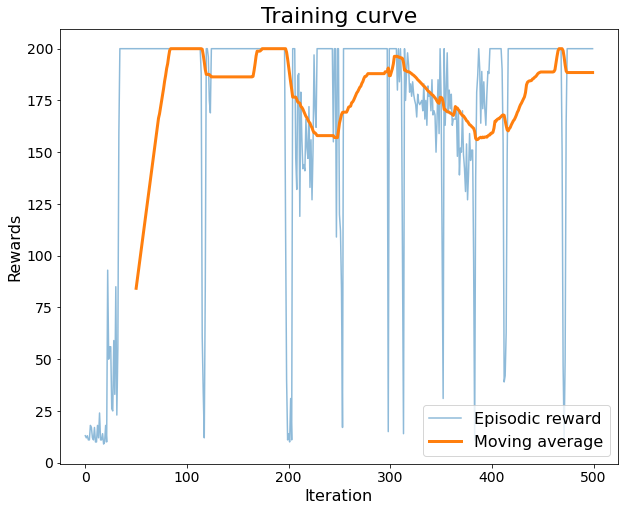

In [7]:
# plot visualizations with the resulting optimal policy
n = 50
MA = np.mean(np.array([total_rewards[i:i+n] for i in range(len(total_rewards)-n)]), axis=1)
fullMA = np.concatenate((np.empty(n),MA))
fullMA[0:n] = np.nan

fig, axes = plt.subplots(figsize=(10,8))
axes.plot(total_rewards, linewidth=1.5, label="Episodic reward", alpha=0.5)
axes.plot(fullMA, linewidth=3, label="Moving average")
axes.set_xlabel('Iteration',fontsize=16)
axes.set_ylabel('Rewards',fontsize=16)
axes.set_title("Training curve", fontsize=22)
axes.tick_params(axis='both', labelsize=14)
axes.legend(fontsize=16)
plt.show()